<a href="https://colab.research.google.com/github/Zurehma/AML_Project/blob/zurehma/code/centralized_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PyTorch version: 2.6.0+cu124
Using device: cpu
Running centralized benchmark with lenet5 on cifar100...

Epoch [1/100] - Learning Rate: 0.010000


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.6081, Train Acc: 1.06%, Test Loss: 4.6080, Test Acc: 1.09%, Time: 35.61s
New best model saved with accuracy: 1.09%

Epoch [2/100] - Learning Rate: 0.009998


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.6079, Train Acc: 1.06%, Test Loss: 4.6076, Test Acc: 1.05%, Time: 34.40s

Epoch [3/100] - Learning Rate: 0.009990


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.6075, Train Acc: 1.08%, Test Loss: 4.6071, Test Acc: 1.08%, Time: 34.03s

Epoch [4/100] - Learning Rate: 0.009978


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.6071, Train Acc: 1.14%, Test Loss: 4.6067, Test Acc: 1.12%, Time: 34.31s
New best model saved with accuracy: 1.12%

Epoch [5/100] - Learning Rate: 0.009961


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.6066, Train Acc: 1.08%, Test Loss: 4.6062, Test Acc: 1.19%, Time: 34.27s
New best model saved with accuracy: 1.19%

Epoch [6/100] - Learning Rate: 0.009938


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.6062, Train Acc: 1.20%, Test Loss: 4.6058, Test Acc: 1.33%, Time: 33.98s
New best model saved with accuracy: 1.33%

Epoch [7/100] - Learning Rate: 0.009911


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.6057, Train Acc: 1.21%, Test Loss: 4.6053, Test Acc: 1.39%, Time: 34.05s
New best model saved with accuracy: 1.39%

Epoch [8/100] - Learning Rate: 0.009880


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.6053, Train Acc: 1.25%, Test Loss: 4.6048, Test Acc: 1.51%, Time: 34.26s
New best model saved with accuracy: 1.51%

Epoch [9/100] - Learning Rate: 0.009843


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.6049, Train Acc: 1.38%, Test Loss: 4.6043, Test Acc: 1.60%, Time: 34.24s
New best model saved with accuracy: 1.60%

Epoch [10/100] - Learning Rate: 0.009801


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.6044, Train Acc: 1.49%, Test Loss: 4.6037, Test Acc: 1.74%, Time: 34.31s
New best model saved with accuracy: 1.74%

Epoch [11/100] - Learning Rate: 0.009755


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.6037, Train Acc: 1.55%, Test Loss: 4.6031, Test Acc: 1.66%, Time: 34.42s

Epoch [12/100] - Learning Rate: 0.009704


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.6031, Train Acc: 1.57%, Test Loss: 4.6024, Test Acc: 1.73%, Time: 34.61s

Epoch [13/100] - Learning Rate: 0.009649


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.6022, Train Acc: 1.57%, Test Loss: 4.6015, Test Acc: 1.80%, Time: 34.35s
New best model saved with accuracy: 1.80%

Epoch [14/100] - Learning Rate: 0.009589


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.6013, Train Acc: 1.61%, Test Loss: 4.6005, Test Acc: 1.83%, Time: 34.13s
New best model saved with accuracy: 1.83%

Epoch [15/100] - Learning Rate: 0.009524


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.6003, Train Acc: 1.68%, Test Loss: 4.5992, Test Acc: 1.84%, Time: 34.02s
New best model saved with accuracy: 1.84%

Epoch [16/100] - Learning Rate: 0.009455


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.5988, Train Acc: 1.73%, Test Loss: 4.5977, Test Acc: 1.81%, Time: 33.97s

Epoch [17/100] - Learning Rate: 0.009382


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.5972, Train Acc: 1.68%, Test Loss: 4.5957, Test Acc: 1.83%, Time: 34.12s

Epoch [18/100] - Learning Rate: 0.009304


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.5951, Train Acc: 1.80%, Test Loss: 4.5932, Test Acc: 1.82%, Time: 34.10s

Epoch [19/100] - Learning Rate: 0.009222


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.5924, Train Acc: 1.81%, Test Loss: 4.5901, Test Acc: 1.93%, Time: 34.52s
New best model saved with accuracy: 1.93%

Epoch [20/100] - Learning Rate: 0.009135


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.5891, Train Acc: 1.86%, Test Loss: 4.5862, Test Acc: 1.96%, Time: 34.25s
New best model saved with accuracy: 1.96%

Epoch [21/100] - Learning Rate: 0.009045


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.5852, Train Acc: 1.88%, Test Loss: 4.5814, Test Acc: 2.02%, Time: 34.29s
New best model saved with accuracy: 2.02%

Epoch [22/100] - Learning Rate: 0.008951


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.5800, Train Acc: 1.94%, Test Loss: 4.5758, Test Acc: 2.24%, Time: 34.42s
New best model saved with accuracy: 2.24%

Epoch [23/100] - Learning Rate: 0.008853


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.5746, Train Acc: 1.98%, Test Loss: 4.5692, Test Acc: 2.23%, Time: 34.72s

Epoch [24/100] - Learning Rate: 0.008751


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.5680, Train Acc: 2.02%, Test Loss: 4.5615, Test Acc: 2.26%, Time: 34.53s
New best model saved with accuracy: 2.26%

Epoch [25/100] - Learning Rate: 0.008645


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.5603, Train Acc: 1.98%, Test Loss: 4.5527, Test Acc: 2.08%, Time: 35.05s

Epoch [26/100] - Learning Rate: 0.008536


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.5521, Train Acc: 1.96%, Test Loss: 4.5432, Test Acc: 2.05%, Time: 34.65s

Epoch [27/100] - Learning Rate: 0.008423


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.5428, Train Acc: 1.87%, Test Loss: 4.5328, Test Acc: 2.10%, Time: 34.58s

Epoch [28/100] - Learning Rate: 0.008307


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.5332, Train Acc: 1.89%, Test Loss: 4.5214, Test Acc: 2.10%, Time: 34.69s

Epoch [29/100] - Learning Rate: 0.008187


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.5236, Train Acc: 1.92%, Test Loss: 4.5093, Test Acc: 2.16%, Time: 35.01s

Epoch [30/100] - Learning Rate: 0.008065


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.5113, Train Acc: 2.24%, Test Loss: 4.4959, Test Acc: 2.38%, Time: 34.96s
New best model saved with accuracy: 2.38%

Epoch [31/100] - Learning Rate: 0.007939


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.4985, Train Acc: 2.26%, Test Loss: 4.4808, Test Acc: 2.52%, Time: 34.91s
New best model saved with accuracy: 2.52%

Epoch [32/100] - Learning Rate: 0.007810


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.4853, Train Acc: 2.50%, Test Loss: 4.4645, Test Acc: 2.87%, Time: 34.82s
New best model saved with accuracy: 2.87%

Epoch [33/100] - Learning Rate: 0.007679


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.4717, Train Acc: 2.67%, Test Loss: 4.4465, Test Acc: 3.21%, Time: 34.80s
New best model saved with accuracy: 3.21%

Epoch [34/100] - Learning Rate: 0.007545


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.4543, Train Acc: 3.07%, Test Loss: 4.4266, Test Acc: 3.40%, Time: 34.82s
New best model saved with accuracy: 3.40%

Epoch [35/100] - Learning Rate: 0.007409


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.4353, Train Acc: 3.23%, Test Loss: 4.4055, Test Acc: 3.85%, Time: 35.08s
New best model saved with accuracy: 3.85%

Epoch [36/100] - Learning Rate: 0.007270


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.4141, Train Acc: 3.57%, Test Loss: 4.3817, Test Acc: 4.28%, Time: 35.05s
New best model saved with accuracy: 4.28%

Epoch [37/100] - Learning Rate: 0.007129


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.3920, Train Acc: 3.85%, Test Loss: 4.3578, Test Acc: 4.34%, Time: 35.21s
New best model saved with accuracy: 4.34%

Epoch [38/100] - Learning Rate: 0.006986


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.3698, Train Acc: 4.12%, Test Loss: 4.3337, Test Acc: 4.91%, Time: 35.34s
New best model saved with accuracy: 4.91%

Epoch [39/100] - Learning Rate: 0.006841


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.3465, Train Acc: 4.58%, Test Loss: 4.3098, Test Acc: 5.55%, Time: 35.21s
New best model saved with accuracy: 5.55%

Epoch [40/100] - Learning Rate: 0.006694


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.3217, Train Acc: 5.09%, Test Loss: 4.2836, Test Acc: 5.88%, Time: 35.39s
New best model saved with accuracy: 5.88%

Epoch [41/100] - Learning Rate: 0.006545


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.2982, Train Acc: 5.48%, Test Loss: 4.2568, Test Acc: 6.18%, Time: 35.57s
New best model saved with accuracy: 6.18%

Epoch [42/100] - Learning Rate: 0.006395


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.2725, Train Acc: 5.60%, Test Loss: 4.2286, Test Acc: 6.22%, Time: 35.43s
New best model saved with accuracy: 6.22%

Epoch [43/100] - Learning Rate: 0.006243


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.2460, Train Acc: 5.68%, Test Loss: 4.2005, Test Acc: 6.23%, Time: 35.12s
New best model saved with accuracy: 6.23%

Epoch [44/100] - Learning Rate: 0.006091


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.2195, Train Acc: 5.87%, Test Loss: 4.1746, Test Acc: 6.37%, Time: 34.86s
New best model saved with accuracy: 6.37%

Epoch [45/100] - Learning Rate: 0.005937


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.1982, Train Acc: 5.87%, Test Loss: 4.1529, Test Acc: 6.80%, Time: 34.96s
New best model saved with accuracy: 6.80%

Epoch [46/100] - Learning Rate: 0.005782


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.1776, Train Acc: 6.12%, Test Loss: 4.1347, Test Acc: 6.83%, Time: 35.07s
New best model saved with accuracy: 6.83%

Epoch [47/100] - Learning Rate: 0.005627


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.1644, Train Acc: 6.37%, Test Loss: 4.1184, Test Acc: 7.08%, Time: 35.12s
New best model saved with accuracy: 7.08%

Epoch [48/100] - Learning Rate: 0.005471


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.1479, Train Acc: 6.55%, Test Loss: 4.1033, Test Acc: 7.11%, Time: 34.88s
New best model saved with accuracy: 7.11%

Epoch [49/100] - Learning Rate: 0.005314


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.1345, Train Acc: 6.78%, Test Loss: 4.0905, Test Acc: 7.53%, Time: 34.91s
New best model saved with accuracy: 7.53%

Epoch [50/100] - Learning Rate: 0.005157


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.1262, Train Acc: 6.92%, Test Loss: 4.0811, Test Acc: 7.58%, Time: 35.13s
New best model saved with accuracy: 7.58%

Epoch [51/100] - Learning Rate: 0.005000


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.1168, Train Acc: 6.82%, Test Loss: 4.0706, Test Acc: 7.57%, Time: 35.21s

Epoch [52/100] - Learning Rate: 0.004843


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.1083, Train Acc: 6.82%, Test Loss: 4.0623, Test Acc: 7.75%, Time: 35.20s
New best model saved with accuracy: 7.75%

Epoch [53/100] - Learning Rate: 0.004686


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.0981, Train Acc: 7.23%, Test Loss: 4.0563, Test Acc: 8.03%, Time: 35.24s
New best model saved with accuracy: 8.03%

Epoch [54/100] - Learning Rate: 0.004529


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.0904, Train Acc: 7.49%, Test Loss: 4.0457, Test Acc: 8.00%, Time: 35.05s

Epoch [55/100] - Learning Rate: 0.004373


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.0835, Train Acc: 7.43%, Test Loss: 4.0392, Test Acc: 8.34%, Time: 34.84s
New best model saved with accuracy: 8.34%

Epoch [56/100] - Learning Rate: 0.004218


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.0799, Train Acc: 7.46%, Test Loss: 4.0354, Test Acc: 8.16%, Time: 34.72s

Epoch [57/100] - Learning Rate: 0.004063


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.0717, Train Acc: 7.66%, Test Loss: 4.0278, Test Acc: 8.50%, Time: 34.68s
New best model saved with accuracy: 8.50%

Epoch [58/100] - Learning Rate: 0.003909


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.0685, Train Acc: 7.68%, Test Loss: 4.0224, Test Acc: 8.41%, Time: 34.73s

Epoch [59/100] - Learning Rate: 0.003757


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.0604, Train Acc: 8.00%, Test Loss: 4.0199, Test Acc: 8.47%, Time: 34.45s

Epoch [60/100] - Learning Rate: 0.003605


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.0554, Train Acc: 7.83%, Test Loss: 4.0113, Test Acc: 8.47%, Time: 34.67s

Epoch [61/100] - Learning Rate: 0.003455


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.0494, Train Acc: 7.97%, Test Loss: 4.0084, Test Acc: 8.82%, Time: 34.79s
New best model saved with accuracy: 8.82%

Epoch [62/100] - Learning Rate: 0.003306


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.0428, Train Acc: 8.02%, Test Loss: 4.0046, Test Acc: 8.89%, Time: 34.48s
New best model saved with accuracy: 8.89%

Epoch [63/100] - Learning Rate: 0.003159


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.0440, Train Acc: 8.03%, Test Loss: 3.9991, Test Acc: 9.02%, Time: 34.50s
New best model saved with accuracy: 9.02%

Epoch [64/100] - Learning Rate: 0.003014


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.0363, Train Acc: 8.35%, Test Loss: 3.9951, Test Acc: 8.69%, Time: 34.54s

Epoch [65/100] - Learning Rate: 0.002871


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.0338, Train Acc: 8.21%, Test Loss: 3.9893, Test Acc: 9.04%, Time: 34.93s
New best model saved with accuracy: 9.04%

Epoch [66/100] - Learning Rate: 0.002730


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.0316, Train Acc: 8.22%, Test Loss: 3.9910, Test Acc: 9.11%, Time: 35.14s
New best model saved with accuracy: 9.11%

Epoch [67/100] - Learning Rate: 0.002591


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.0265, Train Acc: 8.48%, Test Loss: 3.9837, Test Acc: 9.25%, Time: 34.92s
New best model saved with accuracy: 9.25%

Epoch [68/100] - Learning Rate: 0.002455


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.0280, Train Acc: 8.36%, Test Loss: 3.9835, Test Acc: 9.00%, Time: 35.20s

Epoch [69/100] - Learning Rate: 0.002321


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.0225, Train Acc: 8.46%, Test Loss: 3.9820, Test Acc: 9.02%, Time: 34.62s

Epoch [70/100] - Learning Rate: 0.002190


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.0195, Train Acc: 8.59%, Test Loss: 3.9759, Test Acc: 9.36%, Time: 34.59s
New best model saved with accuracy: 9.36%

Epoch [71/100] - Learning Rate: 0.002061


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.0165, Train Acc: 8.57%, Test Loss: 3.9748, Test Acc: 9.43%, Time: 34.89s
New best model saved with accuracy: 9.43%

Epoch [72/100] - Learning Rate: 0.001935


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.0155, Train Acc: 8.49%, Test Loss: 3.9723, Test Acc: 9.20%, Time: 34.63s

Epoch [73/100] - Learning Rate: 0.001813


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.0124, Train Acc: 8.59%, Test Loss: 3.9699, Test Acc: 9.41%, Time: 35.13s

Epoch [74/100] - Learning Rate: 0.001693


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.0065, Train Acc: 8.75%, Test Loss: 3.9685, Test Acc: 9.30%, Time: 35.03s

Epoch [75/100] - Learning Rate: 0.001577


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.0083, Train Acc: 8.67%, Test Loss: 3.9678, Test Acc: 9.35%, Time: 34.80s

Epoch [76/100] - Learning Rate: 0.001464


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.0068, Train Acc: 8.62%, Test Loss: 3.9662, Test Acc: 9.41%, Time: 34.73s

Epoch [77/100] - Learning Rate: 0.001355


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.0061, Train Acc: 8.74%, Test Loss: 3.9630, Test Acc: 9.54%, Time: 35.01s
New best model saved with accuracy: 9.54%

Epoch [78/100] - Learning Rate: 0.001249


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.0038, Train Acc: 8.72%, Test Loss: 3.9616, Test Acc: 9.60%, Time: 34.88s
New best model saved with accuracy: 9.60%

Epoch [79/100] - Learning Rate: 0.001147


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 4.0014, Train Acc: 8.73%, Test Loss: 3.9611, Test Acc: 9.47%, Time: 35.02s

Epoch [80/100] - Learning Rate: 0.001049


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 3.9993, Train Acc: 8.87%, Test Loss: 3.9591, Test Acc: 9.48%, Time: 35.14s

Epoch [81/100] - Learning Rate: 0.000955


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 3.9988, Train Acc: 8.85%, Test Loss: 3.9579, Test Acc: 9.69%, Time: 35.18s
New best model saved with accuracy: 9.69%

Epoch [82/100] - Learning Rate: 0.000865


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 3.9976, Train Acc: 8.88%, Test Loss: 3.9571, Test Acc: 9.69%, Time: 35.31s

Epoch [83/100] - Learning Rate: 0.000778


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 3.9976, Train Acc: 8.90%, Test Loss: 3.9559, Test Acc: 9.74%, Time: 35.42s
New best model saved with accuracy: 9.74%

Epoch [84/100] - Learning Rate: 0.000696


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 3.9972, Train Acc: 8.82%, Test Loss: 3.9544, Test Acc: 9.79%, Time: 35.22s
New best model saved with accuracy: 9.79%

Epoch [85/100] - Learning Rate: 0.000618


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 3.9961, Train Acc: 8.93%, Test Loss: 3.9530, Test Acc: 9.68%, Time: 34.97s

Epoch [86/100] - Learning Rate: 0.000545


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 3.9947, Train Acc: 8.97%, Test Loss: 3.9538, Test Acc: 9.55%, Time: 35.52s

Epoch [87/100] - Learning Rate: 0.000476


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 3.9938, Train Acc: 8.87%, Test Loss: 3.9543, Test Acc: 9.56%, Time: 35.83s

Epoch [88/100] - Learning Rate: 0.000411


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 3.9932, Train Acc: 8.76%, Test Loss: 3.9532, Test Acc: 9.63%, Time: 35.26s

Epoch [89/100] - Learning Rate: 0.000351


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 3.9945, Train Acc: 9.01%, Test Loss: 3.9522, Test Acc: 9.61%, Time: 34.87s

Epoch [90/100] - Learning Rate: 0.000296


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 3.9926, Train Acc: 9.14%, Test Loss: 3.9516, Test Acc: 9.64%, Time: 35.00s

Epoch [91/100] - Learning Rate: 0.000245


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 3.9914, Train Acc: 8.98%, Test Loss: 3.9511, Test Acc: 9.68%, Time: 34.88s

Epoch [92/100] - Learning Rate: 0.000199


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 3.9915, Train Acc: 9.05%, Test Loss: 3.9512, Test Acc: 9.74%, Time: 34.89s

Epoch [93/100] - Learning Rate: 0.000157


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 3.9911, Train Acc: 9.06%, Test Loss: 3.9511, Test Acc: 9.70%, Time: 34.56s

Epoch [94/100] - Learning Rate: 0.000120


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 3.9939, Train Acc: 9.01%, Test Loss: 3.9512, Test Acc: 9.67%, Time: 34.32s

Epoch [95/100] - Learning Rate: 0.000089


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 3.9926, Train Acc: 9.01%, Test Loss: 3.9512, Test Acc: 9.72%, Time: 33.98s

Epoch [96/100] - Learning Rate: 0.000062


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 3.9926, Train Acc: 8.97%, Test Loss: 3.9512, Test Acc: 9.72%, Time: 34.15s

Epoch [97/100] - Learning Rate: 0.000039


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 3.9924, Train Acc: 8.98%, Test Loss: 3.9512, Test Acc: 9.71%, Time: 34.25s

Epoch [98/100] - Learning Rate: 0.000022


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 3.9951, Train Acc: 8.89%, Test Loss: 3.9512, Test Acc: 9.70%, Time: 34.40s

Epoch [99/100] - Learning Rate: 0.000010


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 3.9927, Train Acc: 8.87%, Test Loss: 3.9512, Test Acc: 9.68%, Time: 34.61s

Epoch [100/100] - Learning Rate: 0.000002


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 3.9925, Train Acc: 9.06%, Test Loss: 3.9512, Test Acc: 9.67%, Time: 34.85s
Best model loaded with accuracy: 9.79%


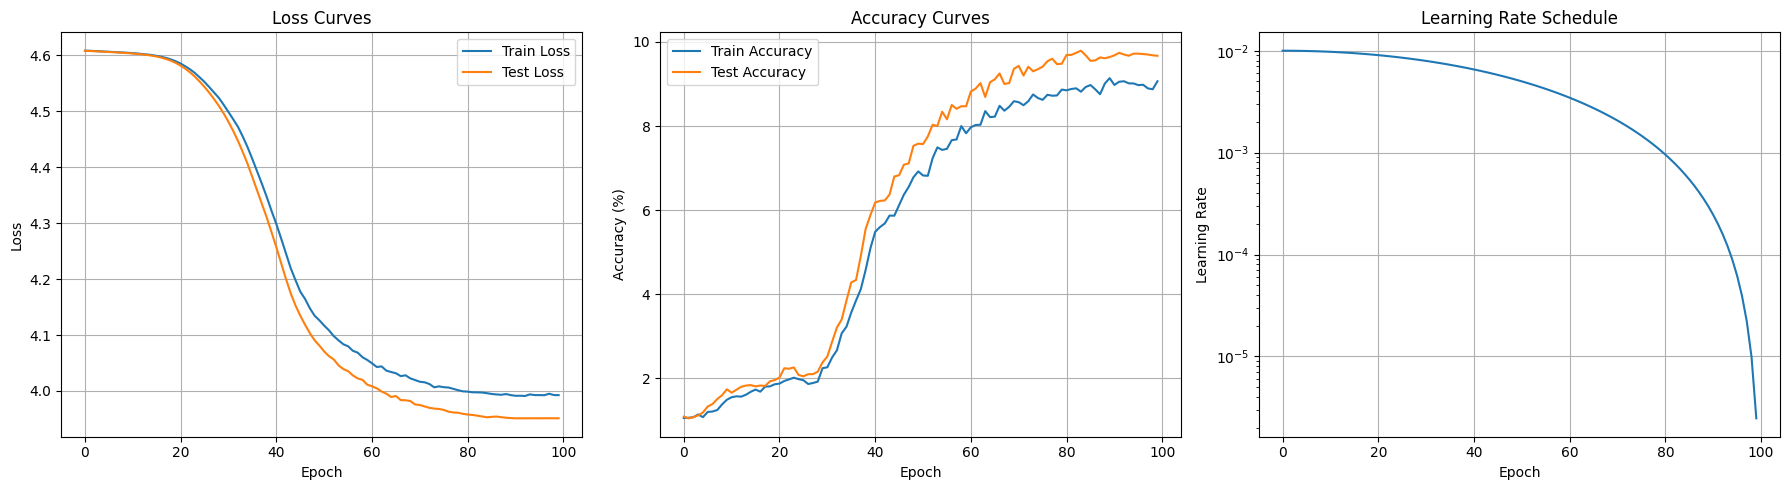

Centralized benchmark completed!


In [3]:
# colab test

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.datasets import CIFAR10, CIFAR100
import torchvision.models as models
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time
import pickle
import numpy as np
import random

print("PyTorch version:", torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Seeding for reproducibility
seed = 2025
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# transforms
train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])


# load data

def load_data(dataset_name="cifar100", batch_size=128, num_workers=2):

    if dataset_name.lower() == "cifar10":
        train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
        test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)
        num_classes = 10
    elif dataset_name.lower() == "cifar100":
        train_dataset = CIFAR100(root='./data', train=True, download=True, transform=train_transform)
        test_dataset = CIFAR100(root='./data', train=False, download=True, transform=test_transform)
        num_classes = 100
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")

    # data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True
    )

    return train_loader, test_loader, num_classes


# model - LeNet5 from the paper [11]
class LeNet5(nn.Module):
  def __init__(self, num_classes=10):
    super(LeNet5, self).__init__()
    # Input: 3x32x32 (CIFAR has 3 color channels)
    self.conv1 = nn.Conv2d(3, 6, kernel_size=5)  # Output: 6x28x28
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 6x14x14
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)  # Output: 16x10x10
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 16x5x5

    # fc layers
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, num_classes)

  def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5) # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def create_model(model_name, num_classes=10):
    if model_name.lower() == "lenet5":
        return LeNet5(num_classes=num_classes)
    else:
        raise ValueError(f"Unknown model: {model_name}")

# train
def train_epoch(model, train_loader, criterion, optimizer, device):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  pbar = tqdm(train_loader, desc="Training")

  for inputs, labels in pbar:
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * inputs.size(0)
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

    # just a progress bar
    pbar.set_postfix({
      'loss': running_loss / total,
      'acc': 100. * correct / total
    })

  train_loss = running_loss / total
  train_acc = 100. * correct / total

  return train_loss, train_acc


# eval
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = running_loss / total
    test_acc = 100. * correct / total

    return test_loss, test_acc


# train config
def train_centralized_model(
    model_name="lenet5",
    dataset_name="cifar100",
    batch_size=8192,
    epochs=100,
    lr=0.01,
    momentum=0.9,
    weight_decay=5e-4,
    lr_scheduler="cosine",
    save_path="lenet5_model.pth"
):
    # load data
    train_loader, test_loader, num_classes = load_data(
        dataset_name=dataset_name,
        batch_size=batch_size
    )

    # model
    model = create_model(model_name, num_classes=num_classes)
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=lr,
        momentum=momentum,
        weight_decay=weight_decay
    )

    # lr
    if lr_scheduler == "step":
        scheduler = torch.optim.lr_scheduler.MultiStepLR(
            optimizer,
            milestones=[int(epochs * 0.5), int(epochs * 0.75)],
            gamma=0.1
        )
    elif lr_scheduler == "cosine":
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=epochs
        )
    else:
        raise ValueError(f"Unknown scheduler: {lr_scheduler}")

    # training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'lr': []
    }

    # track best accuracy
    best_acc = 0.0

    # training loop
    for epoch in range(epochs):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"\nEpoch [{epoch+1}/{epochs}] - Learning Rate: {current_lr:.6f}")

        # training for one epoch
        start_time = time.time()
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_time = time.time() - start_time

        # evaluate on test set
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)

        # step learning rate scheduler
        scheduler.step()

        # stats
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, "
              f"Time: {train_time:.2f}s")

        # save best model
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'test_acc': test_acc,
            }, save_path)
            print(f"New best model saved with accuracy: {test_acc:.2f}%")

        # update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['lr'].append(current_lr)

    # load best model
    checkpoint = torch.load(save_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Best model loaded with accuracy: {checkpoint['test_acc']:.2f}%")

    return model, history

# visualization of model performance
def plot_training_history(history):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # plot the loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['test_loss'], label='Test Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Loss Curves')
    ax1.grid(True)

    # plot accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['test_acc'], label='Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.set_title('Accuracy Curves')
    ax2.grid(True)

    # plot learning rate
    ax3.plot(history['lr'])
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_title('Learning Rate Schedule')
    ax3.set_yscale('log')
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

# run benchmark
def run_centralized_benchmark():
    # LeNet5 config
    config = {
        'model_name': 'lenet5',
        'dataset_name': 'cifar100',
        'batch_size': 8192,
        'epochs': 100,
        'lr': 0.01,
        'momentum': 0.9,
        'weight_decay': 5e-4,
        'lr_scheduler': 'cosine',
        'save_path': 'lenet5_model.pth'
    }

    print(f"Running centralized benchmark with {config['model_name']} on {config['dataset_name']}...")

    # Train model
    model, history = train_centralized_model(**config)

    # Plot results
    plot_training_history(history)

    # Save history
    with open('lenet5_history.pkl', 'wb') as f:
        pickle.dump(history, f)

    print("Centralized benchmark completed!")

    return model, history

# run it
model, history = run_centralized_benchmark()
